# Problem Set 3: Geometry

In [26]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

# Loading data

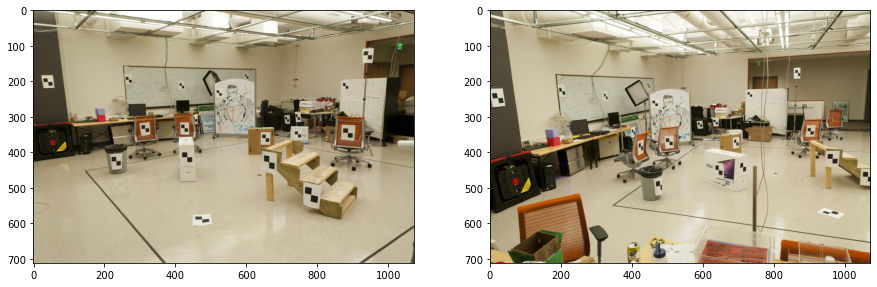

In [2]:
input_dir = Path('input')

img1 = cv2.cvtColor(cv2.imread(str(input_dir / 'pic_a.jpg'), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(str(input_dir / 'pic_b.jpg'), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [3]:
pts3d = np.loadtxt(input_dir / 'pts3d.txt')
pts3d_norm = np.loadtxt(input_dir / 'pts3d-norm.txt')
pts2d_a = np.loadtxt(input_dir / 'pts2d-pic_a.txt')
pts2d_b = np.loadtxt(input_dir / 'pts2d-pic_b.txt')
pts2d_a_norm = np.loadtxt(input_dir / 'pts2d-norm-pic_a.txt')

## Todo

Draw the points on the image

Hint: Use cv2.circle

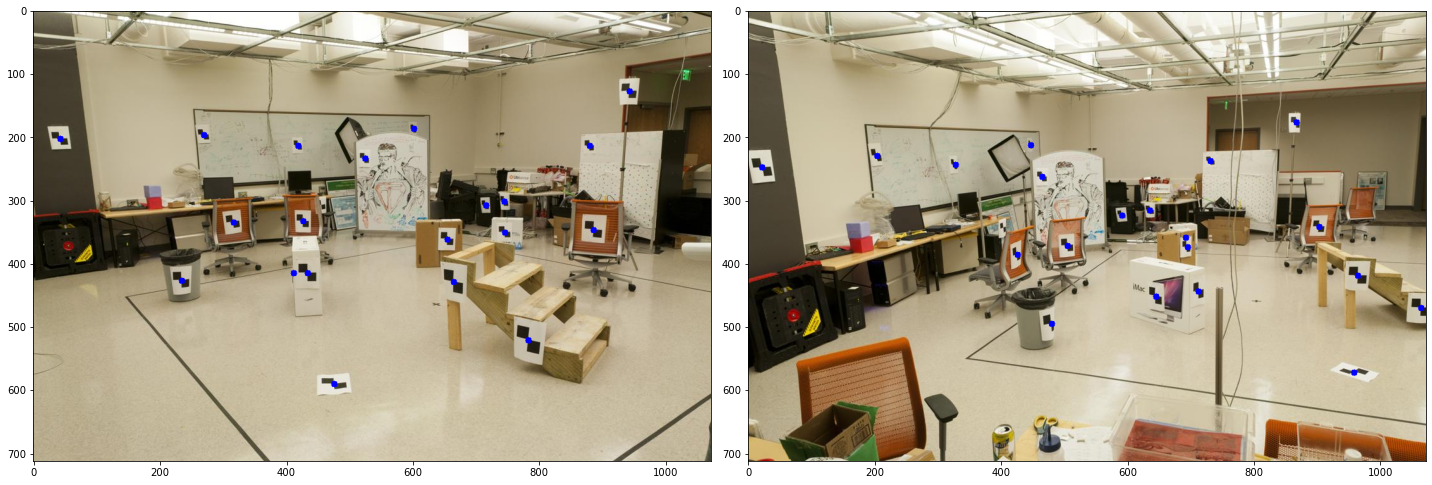

In [4]:
plt.figure(figsize=(20, 10))
for i, (img, pts) in enumerate(zip([img1, img2], [pts2d_a, pts2d_b])):
    img = img.copy()
    for p in pts:
        img = cv2.circle(img, p.astype(int), 5, (0, 0, 255), -1)
    plt.subplot(121 + i)
    plt.imshow(img)
plt.tight_layout()
plt.show()

# Part 1 - Calibration 
The files pts2d-pic_a.txt and pts3d.txt are a list of twenty 2D and 3D points of the image pic_a.jpg. The goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinates. Recall that using homogeneous coordinates the equation is:

$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix} \cong
\begin{bmatrix}
s * u \\
s * v \\
s
\end{bmatrix} =
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & m_{1,4} \\
m_{2,1} & m_{2,2} & m_{2,3} & m_{2,4} \\
m_{3,1} & m_{3,2} & m_{3,3} & m_{3,4}
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

Recall you solve for the 3x4 matrix M using either SVD to solve the homogeneous version of the equations or by setting $m_{3,4}$ to 1 and then using the a normal least squares method. Remember that M is only known up to a scale factor.

To make sure that your code is correct, we are going to give you a set of “normalized points” in the files pts2d-norm-pic_a.txt and pts3d-norm.txt. If you solve for M using all the points you should get a matrix that is a scaled equivalent of the following: 

$$ M_\text{normA} = \begin{bmatrix}
-0.4583 & 0.2947 & 0.0139 & -0.0040 \\
0.0509 & 0.0546 & 0.5410 & 0.0524 \\
-0.1090 & -0.1784 & 0.0443 & -0.5968
\end{bmatrix} $$

For example, this matrix will take the last normalized 3D point which is $< 1.2323, 1.4421, 0.4506, 1.0 >$ and will project it to the $< u, v >$ of $< 0.1419, −0.4518 >$ where we converted the homogeneous 2D point $< u_s, v_s, s >$ to its inhomogeneous version by dividing by s (i.e. the real transformed pixel in the image). 

## Part a

Create the **least squares** function that will solve for the 3x4 matrix $M_{normA}$  given the **normalized** 2D and 3D lists, namely pts2d-norm-pic_a.txt and pts3d-norm.txt.

Test it on the normalized 3D points by multiplying those points by your M matrix and comparing the resulting the normalized 2D points to the normalized 2D points given in the file. Remember to divide by the homogeneous value to get an inhomogeneous point. 

You can do the comparison by checking the residual between the predicted location of each test point using your equation and the actual location given by the 2D input data. The residual is just the distance (square root of the sum of squared differences in u and v). 

In [5]:
def euclidean_to_homogeneous(points):
    ones_shape = [*points.shape[:-1], 1]
    return np.append(points, np.ones(ones_shape), axis=-1)


def homogenous_to_euclidean(points):
    return points[..., :-1] / points[..., [-1]]


def project_points(M, points3d):
    points3d_h = euclidean_to_homogeneous(points3d)
    proj_points_h = points3d_h @ M.T
    proj_points = homogenous_to_euclidean(proj_points_h)
    return proj_points


def compute_geometric_error(points2d, points3d, M):
    proj_points = project_points(M, points3d)
    error = (np.square(proj_points - points2d).sum(-1) ** 0.5).mean()
    return error


def dlt_ls(points2d: np.ndarray, points3d: np.ndarray) -> np.ndarray:
    assert points2d.shape[0] == points3d.shape[0] and points2d.shape[1] == 2 and points3d.shape[1] == 3
    
    A_list = []
    b = []
    
    for p2, p3 in zip(points2d, points3d):
        u, v = p2
        A_list.append([*p3, 1, 0, 0, 0, 0, *(-u * p3)])
        A_list.append([0, 0, 0, 0, *p3, 1, *(-v * p3)])
        b += [u, v]
    
    A = np.array(A_list)
    b = np.array(b)
    
    M, *_ = np.linalg.lstsq(A, b, rcond=None)
    M = np.r_[M, 1].reshape(3, 4)
    return M

In [6]:
M_star = np.array([
    [-0.4583, 0.2947, 0.0139, -0.0040],
    [0.0509, 0.0546, 0.5410, 0.0524],
    [-0.1090, -0.1784, 0.0443, -0.5958]
])

error = compute_geometric_error(pts2d_a_norm, pts3d_norm, M_star)
print('The mean geometric error on the normalized points in scene A using M* is {:.2e}'.format(error))

The mean geometric error on the normalized points in scene A using M* is 2.71e-03


In [7]:
M_norm_a = dlt_ls(pts2d_a_norm, pts3d_norm)
error = compute_geometric_error(pts2d_a_norm, pts3d_norm, M_norm_a)
print('The mean geometric error on the normalized points in scene A is {:.2e}'.format(error))

The mean geometric error on the normalized points in scene A is 2.23e-03


Our matrix reaches an even lower error than theirs... Weird

In [8]:
diff_norm = np.linalg.norm(M_norm_a - M_star / M_star[-1, -1])
print('The norm of the difference between the matrix we found the M* is {:.2e}'.format(diff_norm))

The norm of the difference between the matrix we found the M* is 2.30e-03


The two matrices are very similar

## Part b

Now you are ready to calibrate the camera. Using the 3D and 2D point lists for the image, we’re going to compute the camera projection matrix. To understand the effects of over constraining the system, you’re going to try using sets of 8, 12 and 16 points and then look at the residuals. To debug your code you can use the normalized set from above but for the actual question you’ll need to use: **pts2d-pic_b.txt and pts3d.txt**

For the three point set sizes $k$ of 8, 12, and 16, repeat 10 times:
- Randomly choose k points from the 2D list and their corresponding points in the 3D list.
- Compute the projection matrix M on the chosen points.
- Pick 4 points not in your set of k and compute the average residual error.
- Save the M that gives the lowest residual error.

In [9]:
best_M = None
best_error = np.inf

for k in [8, 12, 16]:
    print(f'k={k}')
    for i in range(10):
        rand_idx = np.random.choice(np.arange(pts2d_b.shape[0]), k + 4, replace=False)
        train_idx, test_idx = rand_idx[:-4], rand_idx[-4:]
        M = dlt_ls(pts2d_b[train_idx], pts3d[train_idx])
        train_error = compute_geometric_error(pts2d_b[train_idx], pts3d[train_idx], M)
        test_error = compute_geometric_error(pts2d_b[test_idx], pts3d[test_idx], M)
        print(f'i={i} train_error={train_error:.2f} test_error={test_error:.2f}', end='')
        if test_error < best_error:
            best_error = test_error
            best_M = M
            print(' New Best!', end='')
        print()

k=8
i=0 train_error=0.39 test_error=2.56 New Best!
i=1 train_error=0.18 test_error=1.08 New Best!
i=2 train_error=0.35 test_error=5.82
i=3 train_error=0.44 test_error=2.96
i=4 train_error=0.26 test_error=1.76
i=5 train_error=0.51 test_error=7.00
i=6 train_error=0.41 test_error=2.08
i=7 train_error=0.35 test_error=2.12
i=8 train_error=0.49 test_error=1.86
i=9 train_error=0.22 test_error=3.69
k=12
i=0 train_error=0.62 test_error=1.04 New Best!
i=1 train_error=0.71 test_error=1.05
i=2 train_error=0.63 test_error=2.26
i=3 train_error=0.66 test_error=1.28
i=4 train_error=0.76 test_error=1.41
i=5 train_error=0.71 test_error=1.49
i=6 train_error=0.61 test_error=0.95 New Best!
i=7 train_error=0.65 test_error=1.18
i=8 train_error=0.51 test_error=1.84
i=9 train_error=0.75 test_error=0.89 New Best!
k=16
i=0 train_error=0.74 test_error=1.42
i=1 train_error=0.79 test_error=0.86 New Best!
i=2 train_error=0.67 test_error=1.46
i=3 train_error=0.70 test_error=1.45
i=4 train_error=0.73 test_error=1.36
i

In [10]:
print(f'The lowest error achieved is {best_error:.2f}')
display(best_M)

The lowest error achieved is 0.73


array([[-2.05e+00,  1.19e+00,  3.79e-01,  2.44e+02],
       [-4.57e-01, -3.02e-01,  2.14e+00,  1.66e+02],
       [-2.25e-03, -1.09e-03,  5.46e-04,  1.00e+00]])

### Part c

Finally we can solve for the camera center in the world. Let us define M as being made up of a 3x3 we’ll call Q and a 4th column will call $m_4
$:

$$M = [\mathbf{Q}|\mathbf{m_4}]$$

From class we said that the center of the camera $C$ could be found by:

$$C= - Q^{-1} \mathbf{m_4}$$

To debug your code: If you use you the normalized 3D points to get the $M_{normA}$ given above you would get a camera center of:

$$C_{normA} = < -1.5125, -2.3515, 0.2826 >$$
Given the best M from the last part, compute $C$.

In [11]:
def find_camera_center(M):
    Q, m4 = M[:, :3], M[:, 3]
    C = - np.linalg.inv(Q) @ m4
    return C

Let's test our code on the normalized points:

In [12]:
find_camera_center(M_norm_a)

array([-1.51, -2.35,  0.28])

This is very close to the value it should be. Our implementation is correct.

In [13]:
find_camera_center(best_M)

array([303.09, 307.18,  30.42])

This is the approximate location of camera b in real world coordinates.

# Part 2 - Fundamental Matrix Estimation

We now wish to estimate the mapping of points in one image to lines in another by means of the fundamental matrix. This will require you to use similar methods to those in question 1. We will make use of the corresponding point locations listed in **pts2d-pic_a.txt and pts2d-pic_b.txt**.

Recall that the definition of the Fundamental Matrix is:

$$
\begin{bmatrix} u' & v' & 1 \end{bmatrix}
\begin{bmatrix}
f_{1,1} & f_{1,2} & f_{1,3} \\
f_{2,1} & f_{2,2} & f_{2,3} \\
f_{3,1} & f_{3,2} & f_{3,3}
\end{bmatrix}
\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = 0
$$

Given corresponding points you get one equation per point pair. With 8 or more points you can solve this. With more points (such as the 20 in the files) you solve using the the same least squares method as in question 1 above.

## Part a

Create the least squares function that will solve for the 3x3 matrix $\hat{F}$ that satisfies the epipolar constraints defined by the sets of corresponding points. Solve this function to create your least squares estimate of the 3x3 transform $\hat{F}$.

In [14]:
def find_F_ls(points_a, points_b):
    A_list = []
    points_a_h = euclidean_to_homogeneous(points_a)
    points_b_h = euclidean_to_homogeneous(points_b)
    for p1, p2 in zip(points_a_h, points_b_h):
#         A_list.append([p1[0] * p2[0], p1[0] * p2[1], p1[0] * p2[2], 
#                        p1[1] * p2[0], p1[1] * p2[1], p1[1] * p2[2],
#                        p2[0], p2[1]])
        A_list.append((np.outer(p1, p2)).flatten()[:-1])
    A = np.array(A_list)
    b = - np.ones(A.shape[0])
    F, *_ = np.linalg.lstsq(A, b, rcond=None)
    F = np.r_[F, 1].reshape((3, 3))
    return F

In [15]:
F = find_F_ls(pts2d_a, pts2d_b)
display(F)

array([[-6.61e-07,  8.83e-06, -9.09e-04],
       [ 7.91e-06,  1.22e-06, -2.64e-02],
       [-1.88e-03,  1.72e-02,  1.00e+00]])

In [16]:
pts2d_a_h = euclidean_to_homogeneous(pts2d_a)
pts2d_b_h = euclidean_to_homogeneous(pts2d_b)
residual = np.mean(np.abs(np.diag(pts2d_a_h @ F @ pts2d_b_h.T)))
print('The mean residual of the fundemental matrix is {:.2e}'.format(residual))

The mean residual of the fundemental matrix is 1.53e-02


## Part b

The linear squares estimate of $\hat{F}$ is full rank; however, the fundamental matrix is a rank 2 matrix. As such we must reduce its rank. 
In order to do this we can decompose $\hat{F}$ using singular value decomposition into the matrices $U \Sigma V^T = \hat{F}$. 
We can then estimate a rank 2 matrix by setting the smallest singular value in $\Sigma$ to zero thus generating $\Sigma'$. 
The fundamental matrix is then easily calculated as $F=U \Sigma' V^T$. Use the SVD function to do, well, the SVD. Duh.

In [17]:
def turn_singular(M):
    U, S, Vh = np.linalg.svd(M)
    S[-1] = 0
    M_sing = (U * S) @ Vh
    return M_sing

In [18]:
F_sing = turn_singular(F)
display(F_sing)

array([[-5.36e-07,  8.84e-06, -9.09e-04],
       [ 7.90e-06,  1.22e-06, -2.64e-02],
       [-1.88e-03,  1.72e-02,  1.00e+00]])

In [19]:
print('The singular values of the linear estimate of F are: {}'.format(np.linalg.svd(F)[1]))
print('The singular values of the new F are: {}'.format(np.linalg.svd(F_sing)[1]))
print('The absolute difference between the matrices is {:.2e}'.format(np.linalg.norm(F - F_sing)))

The singular values of the linear estimate of F are: [1.00e+00 4.59e-04 1.25e-07]
The singular values of the new F are: [1.00e+00 4.59e-04 6.82e-19]
The absolute difference between the matrices is 1.25e-07


## Part c

Now you can use your matrix $F$ to estimate an epipolar line $l_b$ in image ‘b’ corresponding to point $p_a$ in image ‘a’: $l_b = F p_a$.

Similarly, epipolar lines in image a corresponding to points in image b are related by the transpose of $F$.

**Note: These relations might be reversed depending on how you computed $F$.**

Draw these epipolar lines. Below is one way; the key is to be able to take the projective geometry form of the line and draw it in the image:

- The resulting lines $l_i$ defined in homogeneous coordinates can not be drawn directly using standard line functions, which take as input two points. In order to use such functions, we can find the intersection of a given line $l_i$ with the image boundaries.
- If we define $l_L$ to be the line corresponding to the left hand side of the image and $l_R$ to be the line corresponding to the right hand side of the image, we can find the points $P_{u,L} = l_i \times i_L$ and $P_{u,R} = l_i \times i_R$. We can now plot the line running through the points $P_{u,L}$, $P_{u,R}$.
- However, we must first have the equations for $l_L$ and $l_R$. Making use of the point-line duality, we know, e.g., $l_L = P_{UL} \times P_{BL}$. Where $P_{UL}$ is the point defining the upper left-hand corner of the image and $P_{BL}$ is the bottom left-hand corner of the image.
- An example of such an image is:

![epipolar lines image a](images/epipolar_lines_gt.png)

In [20]:
def draw_epipolar_lines(img, pts, other_pts, F):
    img = img.copy()
    H, W, _ = img.shape
    line_L = np.cross([0, 0, 1], [0, H, 1])
    line_R = np.cross([W, 0, 1], [W, H, 1])
    
    pts_h = euclidean_to_homogeneous(other_pts)
    for j, p in enumerate(pts_h):
        epi_line = F @ p
        left_coord = homogenous_to_euclidean(np.cross(line_L, epi_line)).astype(int)
        right_coord = homogenous_to_euclidean(np.cross(line_R, epi_line)).astype(int)
        cv2.line(img, left_coord, right_coord, (0, 0, 255), 1)
        cv2.circle(img, pts[j].astype(int), 5, (0, 255, 0), -1)
    return img

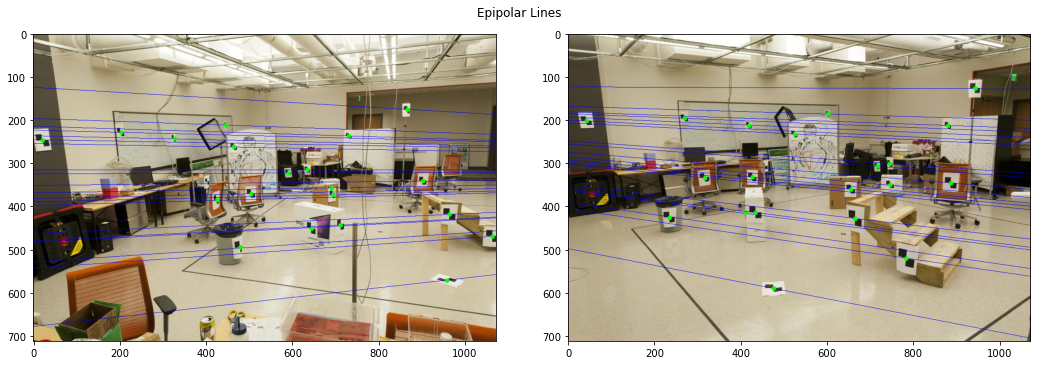

In [21]:
plt.figure(figsize=(15, 5))
plt.suptitle('Epipolar Lines')
plt.subplot(121)
plt.imshow(draw_epipolar_lines(img2, pts2d_b, pts2d_a, F.T))
plt.subplot(122)
plt.imshow(draw_epipolar_lines(img1, pts2d_a, pts2d_b, F))
plt.tight_layout()
plt.show()

### Question

Look at the result you got for image a, how do they compare to the ground truth?

![epipolar lines image a](images/epipolar_lines_gt.png)

### Answer

It seems like the epipolar lines are close but not quite it, they assume that the epipole is closer than it really is.

# EXTRA CREDIT PROBLEMS (2-d and 2-e)


## Part d

If you look at the results of the last section the epipolar lines are close, but not perfect. The problem is that the offset and scale of the points is large and biased compared to some of the constants. To fix this, we are going to normalize the points.

In the 2D case this normalization is really easy. We want to construct transformations that make the mean of the points zero and, optionally, scale them so that their magnitude is about 1.0 or some other not too large number:

$$
\begin{bmatrix}
u' \\
v' \\
1
\end{bmatrix} =
\begin{bmatrix}
s & 0 & 0 \\
0 & s & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & -c_u \\
0 & 1 & -c_v \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

The transform matrix $T$ is the product of the scale and offset matrices. The $c_u, c_v$ is just the mean. To compute a scale $s$ you could estimate the standard deviation after subtracting the means. Or you could find the maximum absolute value. Then the scale factor $s$ would be the reciprocal of whatever estimate of the scale you are using.

Create two matrices $T_a$ and $T_b$ for the set of points defined in the files **pts2d-pic_a.txt and pts2d-pic_b.txt** respectively. 
Use these matrices to transform the two sets of points. 
Then use these normalized points to create a new Fundamental matrix $\hat{F}$. Compute it as above including making the smaller singular value zero.

In [22]:
def normalize_points(pts):
    cu, cv = pts.mean(0)
    s = 1 / (pts - pts.mean(0)).std()
    T = np.array([[s, 0, - s * cu],
                  [0, s, - s * cv], 
                  [0, 0, 1]])
    pts_h = euclidean_to_homogeneous(pts)
    pts_h_norm = pts_h @ T.T
    return homogenous_to_euclidean(pts_h_norm), T

In [ ]:
pts2d_a_norm, T_a = normalize_points(pts2d_a)
pts2d_b_norm, T_b = normalize_points(pts2d_b)

print('T_a')
display(T_a)
print('T_b')
display(T_b)

F_norm = find_F_ls(pts2d_a_norm, pts2d_b_norm)
print('F_norm')
display(F_norm)

F_norm_sing = turn_singular(F_norm)
print('Singular F_norm')
display(F_norm_sing)

print('The singular values of the linear estimate of F_norm are: {}'.format(np.linalg.svd(F_norm)[1]))
print('The singular values of the new F_norm are: {}'.format(np.linalg.svd(F_norm_sing)[1]))
print('The absolute difference between the matrices is {:.2e}'.format(np.linalg.norm(F_sing - F_norm_sing)))

## Part e

Finally you can create a better $F$ by: $F = T_b^T \hat{F} T_a$

Using this new  redraw the epipolar lines of 2-c. They should be better.

In [ ]:
F_rescale = T_a.T @ F_norm_sing @ T_b
print('Rescaled F')
display(F_rescale)

plt.figure(figsize=(15, 5))
plt.suptitle('Epipolar Lines with Normalization')
plt.subplot(121)
plt.imshow(draw_epipolar_lines(img2, pts2d_b, pts2d_a, F_rescale.T))
plt.subplot(122)
plt.imshow(draw_epipolar_lines(img1, pts2d_a, pts2d_b, F_rescale))
plt.tight_layout()
plt.show()

### Question

Again, look at the new result for, how do they compare to the ground truth?

![epipolar lines image a](images/epipolar_lines_gt.png)

### Answer

They are still not perfect* but they are better than before.

\*As you can see on the bottom line's proximity to the wire in the left side of the images and in the top line's proximity to the ceiling.